<a href="https://colab.research.google.com/github/jeehyun100/MTCNN/blob/master/Dqn_breakout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

!apt-get install x11-utils > /dev/null 2>&1 and !pip install pyglet==v1.3.

In [0]:
!pip install gym --upgrade > /dev/null 2>&1

In [4]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '400x300x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

# Import library

In [0]:
# -*- coding: utf-8 -*-
# 김성훈님 ( https://github.com/hunkim/ReinforcementZeroToAll/blob/master/07_3_dqn_2015_cartpole.py )
# 김태훈님 ( https://github.com/devsisters/DQN-tensorflow )
# 코드를 참조했습니다. 감사합니다!
#

import tensorflow as tf
import gym

import numpy as np
import random as ran
import datetime
import matplotlib.pyplot as plt

from collections import deque
from skimage.transform import resize
from skimage.color import rgb2gray

plt.ion()
# DQN paper setting(frameskip = 4, repeat_action_probability = 0)
# {}Deterministic : frameskip = 4
# {}-v4 : repeat_action_probability
env = gym.make('BreakoutDeterministic-v4')
#GoalEnv
# 하이퍼 파라미터
MINIBATCH_SIZE = 32
HISTORY_SIZE = 4
TRAIN_START = 50000
FINAL_EXPLORATION = 0.1
TARGET_UPDATE = 10000
MEMORY_SIZE = 400000
EXPLORATION = 1000000
START_EXPLORATION = 1.
INPUT = env.observation_space.shape[0]
OUTPUT = env.action_space.n
#print(env.action_space.n)
HEIGHT = 84
WIDTH = 84
LEARNING_RATE = 0.00025
DISCOUNT = 0.99
EPSILON = 0.01
MOMENTUM = 0.95
#NUM_ACTIONS = env.action_space.n
#model_path = "/content/drive/My Drive/save/Breakout2.ckpt"
model_path = "/content/drive/My Drive/save/Breakout_gpu.ckpt"

# Util Methond

In [0]:

def cliped_error(error):
    '''후버로스를 사용하여 error 클립.
    
    Args:
        error(tensor): 클립을 해야할 tensor
        
    Returns:
        tensor: -1 ~ 1 사이로 클립된 error
    '''
    return tf.where(tf.abs(error) < 1.0, 0.5 * tf.square(error), tf.abs(error) - 0.5)

def pre_proc(X):
    '''입력데이터 전처리.
    
    Args:
        X(np.array): 받아온 이미지를 그레이 스케일링 후 84X84로 크기변경
            그리고 정수값으로 저장하기위해(메모리 효율 높이기 위해) 255를 곱함
        
    Returns:
        np.array: 변경된 이미지
    '''
    # 바로 전 frame과 비교하여 max를 취함으로써 flickering을 제거
    # x = np.maximum(X, X1)
    # 그레이 스케일링과 리사이징을 하여 데이터 크기 수정
    x = np.uint8(resize(rgb2gray(X), (HEIGHT, WIDTH), mode='reflect') * 255)
    #print(x.shape)
    return x


def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    '''타겟네트워크에 메인네트워크의 Weight값을 복사.
    
    Args:
        dest_scope_name="target"(DQN): 'target'이라는 이름을 가진 객체를 가져옴
        src_scope_name="main"(DQN): 'main'이라는 이름을 가진 객체를 가져옴
        
    Returns:
        list: main의 trainable한 값들이 target의 값으로 복사된 값
    '''
    op_holder = []

    src_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)

    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))

    return op_holder

def get_init_state(history, s):
    '''에피소드 시작 State를 초기화.
    
    Args:
        history(np.array): 5개의 프레임이 저장될 array
        s(list): 초기화된 이미지
        
    Note:
        history[:,:,:3]에 모두 초기화된 이미지(s)를 넣어줌
    '''
    for i in range(HISTORY_SIZE):
        history[:, :, i] = pre_proc(s)

def get_game_type(count, l, no_life_game, start_live):
    '''라이프가 있는 게임인지 판별
    
    Args:
        count(int): 에피소드 시작 후 첫 프레임인지 확인하기 위한 arg
        l(dict): 라이프 값들이 저장되어있는 dict ex) l['ale.lives']
        no_life_game(bool): 라이프가 있는 게임일 경우, bool 값을 반환해주기 위한 arg
        start_live(int): 라이프가 있는 경우 라이프값을 초기화 하기 위한 arg
    
    Returns:
        list:
            no_life_game(bool): 라이프가 없는 게임이면 True, 있으면 False
            start_live(int): 라이프가 있는 게임이면 초기화된 라이프
    '''
    if count == 1:
        start_live = l['ale.lives']
        # 시작 라이프가 0일 경우, 라이프 없는 게임
        if start_live == 0:
            no_life_game = True
        else:
            no_life_game = False
    return [no_life_game, start_live]

def get_terminal(start_live, l, reward, no_life_game, ter):
    '''목숨이 줄어들거나, negative reward를 받았을 때, terminal 처리
    
    Args:
        start_live(int): 라이프가 있는 게임일 경우, 현재 라이프 수
        l(dict): 다음 상태에서 라이프가 줄었는지 확인하기 위한 다음 frame의 라이프 info
        no_life_game(bool): 라이프가 없는 게임일 경우, negative reward를 받으면 terminal 처리를 해주기 위한 게임 타입
        ter(bool): terminal 처리를 저장할 arg
        
    Returns:
        list:
            ter(bool): terminal 상태
            start_live(int): 줄어든 라이프로 업데이트된 값
    '''
    if no_life_game:
        # 목숨이 없는 게임일 경우 Terminal 처리
        if reward < 0:
            ter = True
    else:
        # 목숨 있는 게임일 경우 Terminal 처리
        if start_live > l['ale.lives']:
            ter = True
            start_live = l['ale.lives']

    return [ter, start_live]

def train_minibatch(mainDQN, targetDQN, minibatch):
    '''미니배치로 가져온 sample데이터로 메인네트워크 학습
    
    Args:
        mainDQN(object): 메인 네트워크
        targetDQN(object): 타겟 네트워크
        minibatch: replay_memory에서 MINIBATCH 개수만큼 랜덤 sampling 해온 값
        
    Note:
        replay_memory에서 꺼내온 값으로 메인 네트워크를 학습
    '''
    s_stack = []
    a_stack = []
    r_stack = []
    s1_stack = []
    d_stack = []

    for s_r, a_r, r_r, d_r in minibatch:
        s_stack.append(s_r[:, :, :4])
        a_stack.append(a_r)
        r_stack.append(r_r)
        s1_stack.append(s_r[:, :, 1:])
        d_stack.append(d_r)

    # True, False 값을 1과 0으로 변환
    d_stack = np.array(d_stack) + 0

    Q1 = targetDQN.get_q(np.array(s1_stack))

    y = r_stack + (1 - d_stack) * DISCOUNT * np.max(Q1, axis=1)

    # 업데이트 된 Q값으로 main네트워크를 학습
    mainDQN.sess.run(mainDQN.train, feed_dict={mainDQN.X: np.float32(np.array(s_stack) / 255.), mainDQN.Y: y,
                                               mainDQN.a: a_stack})


# 데이터 플롯
def plot_data(epoch, epoch_score, average_reward, epoch_Q, average_Q, mainDQN):
    plt.clf()
    epoch_score.append(np.mean(average_reward))
    epoch_Q.append(np.mean(average_Q))

    plt.subplot(211)
    plt.axis([0, epoch, 0, np.max(epoch_Q) * 6 / 5])
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Action Value(Q)')
    plt.plot(epoch_Q)

    plt.subplot(212)
    plt.axis([0, epoch, 0, np.max(epoch_score) * 6 / 5])
    plt.xlabel('Training Epochs')
    plt.ylabel('Average Reward per Episode')
    plt.plot(epoch_score, "r")

    plt.pause(0.05)
    #plt.savefig("graph/{} epoch".format(epoch - 1))

    save_path = mainDQN.saver.save(mainDQN.sess, model_path, global_step=(epoch - 1))
    print("Model(epoch :", epoch, ") saved in file: ", save_path, " Now time : ", datetime.datetime.now())



# DQN Network

In [0]:
# DQN
class DQNAgent:
    def __init__(self, sess, HEIGHT, WIDTH, HISTORY_SIZE, OUTPUT, NAME='main'):
        self.sess = sess
        self.height = HEIGHT
        self.width = WIDTH
        self.history_size = HISTORY_SIZE
        self.output = OUTPUT
        self.name = NAME

        self.build_network()

    def build_network(self):
        with tf.variable_scope(self.name):
            self.X = tf.placeholder('float', [None, self.height, self.width, self.history_size])
            self.Y = tf.placeholder('float', [None])
            self.a = tf.placeholder('int64', [None])

            f1 = tf.get_variable("f1", shape=[8, 8, 4, 32], initializer=tf.contrib.layers.xavier_initializer_conv2d())
            f2 = tf.get_variable("f2", shape=[4, 4, 32, 64], initializer=tf.contrib.layers.xavier_initializer_conv2d())
            f3 = tf.get_variable("f3", shape=[3, 3, 64, 64], initializer=tf.contrib.layers.xavier_initializer_conv2d())
            w1 = tf.get_variable("w1", shape=[7 * 7 * 64, 512], initializer=tf.contrib.layers.xavier_initializer())
            w2 = tf.get_variable("w2", shape=[512, OUTPUT], initializer=tf.contrib.layers.xavier_initializer())

            c1 = tf.nn.relu(tf.nn.conv2d(self.X, f1, strides=[1, 4, 4, 1], padding="VALID"))
            c2 = tf.nn.relu(tf.nn.conv2d(c1, f2, strides=[1, 2, 2, 1], padding="VALID"))
            c3 = tf.nn.relu(tf.nn.conv2d(c2, f3, strides=[1, 1, 1, 1], padding='VALID'))

            l1 = tf.reshape(c3, [-1, w1.get_shape().as_list()[0]])
            l2 = tf.nn.relu(tf.matmul(l1, w1))

            self.Q_pre = tf.matmul(l2, w2)

        a_one_hot = tf.one_hot(self.a, self.output, 1.0, 0.0)
        q_val = tf.reduce_sum(tf.multiply(self.Q_pre, a_one_hot), reduction_indices=1)

        # error를 -1~1 사이로 클립
        error = cliped_error(self.Y - q_val)

        self.loss = tf.reduce_mean(error)

        optimizer = tf.train.RMSPropOptimizer(LEARNING_RATE, momentum=MOMENTUM, epsilon=EPSILON)
        self.train = optimizer.minimize(self.loss)

        self.saver = tf.train.Saver(max_to_keep=None)

    def get_q(self, history):
        return self.sess.run(self.Q_pre, feed_dict={self.X: np.reshape(np.float32(history / 255.),
                                                                       [-1, 84, 84, 4])})

    def get_action(self, q, e):
        if e > np.random.rand(1):
            #print("random")
            action = np.random.randint(self.output)
        else:
            #print("max")
            action = np.argmax(q)
        return action
    
    def load(self, file_path, epoch):
        """load 
        """
        self.saver.restore(self.sess, file_path +'-'+ str(epoch))
        print("load complete")
        #self.saver.save(self.session, file_path)
        #saver.save(sess, checkpoint_path, global_step=step)


In [0]:
# Trainning

In [0]:


def main():
    with tf.Session() as sess:
        mainDQN = DQNAgent(sess, HEIGHT, WIDTH, HISTORY_SIZE, OUTPUT, NAME='main')
        targetDQN = DQNAgent(sess, HEIGHT, WIDTH, HISTORY_SIZE, OUTPUT, NAME='target')

        sess.run(tf.global_variables_initializer())

        # initial copy q_net -> target_net
        copy_ops = get_copy_var_ops(dest_scope_name="target",
                                    src_scope_name="main")
        sess.run(copy_ops)

        recent_rlist = deque(maxlen=100)
        e = 1.
        episode, epoch, frame = 0, 0, 0

        epoch_score, epoch_Q = deque(), deque()
        average_Q, average_reward = deque(), deque()

        epoch_on = False
        no_life_game = False
        replay_memory = deque(maxlen=MEMORY_SIZE)

        # Train agent during 200 epoch
        while epoch <= 1:
            episode += 1

            history = np.zeros([84, 84, 5], dtype=np.uint8)
            rall, count = 0, 0
            d = False
            ter = False
            start_lives = 0
            s = env.reset()

            get_init_state(history, s)

            while not d:
                # env.render()

                frame += 1
                count += 1

                # e-greedy
                if e > FINAL_EXPLORATION and frame > TRAIN_START:
                    e -= (START_EXPLORATION - FINAL_EXPLORATION) / EXPLORATION

                # 히스토리의 0~4까지 부분으로 Q값 예측
                Q = mainDQN.get_q(history[:, :, :4])
                average_Q.append(np.max(Q))

                # 액션 선택
                action = mainDQN.get_action(Q, e)

                # 액션 개수 줄임(for Breakout)
                '''
                if action == 0:
                    real_a = 1
                elif action == 1:
                    real_a = 4
                else:
                    real_a = 5
                '''

                # s1 : next frame / r : reward / d : done(terminal) / l : info(lives)
                s1, r, d, l = env.step(action)
                ter = d
                reward = np.clip(r, -1, 1)

                # 라이프가 있는 게임인지 아닌지 판별
                no_life_game, start_lives = get_game_type(count, l, no_life_game, start_lives)

                # 라이프가 줄어들거나 negative 리워드를 받았을 때 terminal 처리를 해줌
                ter, start_lives = get_terminal(start_lives, l, reward, no_life_game, ter)

                # 새로운 프레임을 히스토리 마지막에 넣어줌
                history[:, :, 4] = pre_proc(s1)

                # 메모리 저장 효율을 높이기 위해 5개의 프레임을 가진 히스토리를 저장
                # state와 next_state는 3개의 데이터가 겹침을 이용.
                replay_memory.append((np.copy(history[:, :, :]), action, reward, ter))
                history[:, :, :4] = history[:, :, 1:]

                rall += r

                if frame > TRAIN_START:
                    # 프레임 스킵때마다 학습
                    minibatch = ran.sample(replay_memory, MINIBATCH_SIZE)
                    train_minibatch(mainDQN, targetDQN, minibatch)

                    # 1만 프레임일때마다 target_net 업데이트
                    if frame % TARGET_UPDATE == 0:
                        copy_ops = get_copy_var_ops(dest_scope_name="target",
                                                    src_scope_name="main")
                        sess.run(copy_ops)

                # 1 epoch(trained 50000 frame)마다 plot
                if (frame - TRAIN_START) % 50000 == 0:
                    epoch_on = True

            recent_rlist.append(rall)

            average_reward.append(rall)

            print("Episode:{0:6d} | Frames:{1:9d} | Steps:{2:5d} | Reward:{3:3.0f} | e-greedy:{4:.5f} | "
                  "Avg_Max_Q:{5:2.5f} | Recent reward:{6:.5f}  ".format(episode, frame, count, rall, e,
                                                                        np.mean(average_Q),
                                                                        np.mean(recent_rlist)))

            if epoch_on:
                epoch += 1
                plot_data(epoch, epoch_score, average_reward, epoch_Q, average_Q, mainDQN)
                epoch_on = False
                average_reward = deque()
                average_Q = deque()



Episode:     1 | Frames:      219 | Steps:  219 | Reward:  2 | e-greedy:1.00000 | Avg_Max_Q:0.09228 | Recent reward:2.00000  
Episode:     2 | Frames:      372 | Steps:  153 | Reward:  0 | e-greedy:1.00000 | Avg_Max_Q:0.09311 | Recent reward:1.00000  
Episode:     3 | Frames:      671 | Steps:  299 | Reward:  4 | e-greedy:1.00000 | Avg_Max_Q:0.09425 | Recent reward:2.00000  
Episode:     4 | Frames:      885 | Steps:  214 | Reward:  2 | e-greedy:1.00000 | Avg_Max_Q:0.09392 | Recent reward:2.00000  
Episode:     5 | Frames:     1069 | Steps:  184 | Reward:  1 | e-greedy:1.00000 | Avg_Max_Q:0.09379 | Recent reward:1.80000  
Episode:     6 | Frames:     1248 | Steps:  179 | Reward:  1 | e-greedy:1.00000 | Avg_Max_Q:0.09393 | Recent reward:1.66667  
Episode:     7 | Frames:     1390 | Steps:  142 | Reward:  0 | e-greedy:1.00000 | Avg_Max_Q:0.09400 | Recent reward:1.42857  
Episode:     8 | Frames:     1572 | Steps:  182 | Reward:  1 | e-greedy:1.00000 | Avg_Max_Q:0.09400 | Recent reward:1.

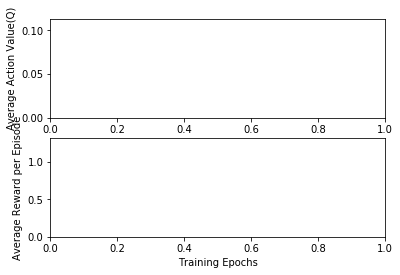

INFO:tensorflow:/content/drive/My Drive/save/Breakout2.ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
Model(epoch : 1 ) saved in file:  /content/drive/My Drive/save/Breakout2.ckpt-0  Now time :  2019-10-31 01:02:47.792761
Episode:   282 | Frames:    50315 | Steps:  171 | Reward:  1 | e-greedy:0.99972 | Avg_Max_Q:0.10188 | Recent reward:1.12000  
Episode:   283 | Frames:    50456 | Steps:  141 | Reward:  0 | e-greedy:0.99959 | Avg_Max_Q:0.10164 | Recent reward:1.10000  
Episode:   284 | Frames:    50663 | Steps:  207 | Reward:  2 | e-greedy:0.99940 | Avg_Max_Q:0.10440 | Recent reward:1.09000  
Episode:   285 | Frames:    50850 | Steps:  187 | Reward:  1 | e-greedy:0.99924 | Avg_Max_Q:0.10378 | Recent reward:1.09000  
Episode:   286 | Frames:    50990 | Steps:  140 | Reward:  0 | e-greedy:0.99911 | Avg_Max_Q:0.10376 | Recent reward:1.09000  
Episode:   287 | Frames:    51120 | Steps:  130 | Reward:  0 | e-greedy:0.99899 | Avg_Max_Q:0.10391 | Recent reward:1.07000  
Epis

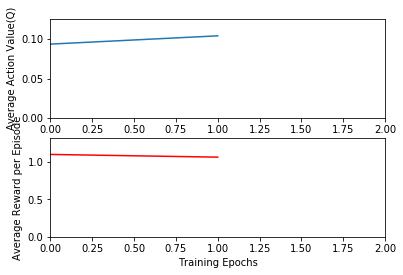

INFO:tensorflow:/content/drive/My Drive/save/Breakout2.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
Model(epoch : 2 ) saved in file:  /content/drive/My Drive/save/Breakout2.ckpt-1  Now time :  2019-10-31 01:29:07.148255


In [0]:
tf.reset_default_graph()
main()

# Test

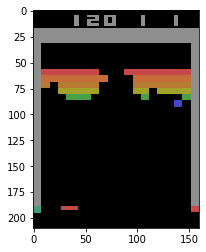

In [11]:
from pyvirtualdisplay import Display
Display().start()

import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')
img = plt.imshow(env.render('rgb_array')) # only call this once

history = np.zeros([84, 84, 5], dtype=np.uint8)
rall, count = 0, 0
d = False
ter = False
start_lives = 0
s = env.reset()
get_init_state(history, s)

average_Q, average_reward = deque(), deque()

with tf.Session() as sess:
    mainDQN = DQNAgent(sess, HEIGHT, WIDTH, HISTORY_SIZE, OUTPUT, NAME='main')
    mainDQN.load(model_path, 64)
    is_done = False
    while not is_done:
      display.display(plt.gcf())
      display.clear_output(wait=True)
      # Perform a random action, returns the new frame, reward and whether the game is over
      # 히스토리의 0~4까지 부분으로 Q값 예측
      Q = mainDQN.get_q(history[:, :, :4]) 
      action = mainDQN.get_action(Q, 0.1)
      #action = env.action_space.sample()
      #print(action)
      s1, r, d, l = env.step(action)
      is_done = d
      #print(l)
      # 새로운 프레임을 히스토리 마지막에 넣어줌
      history[:, :, 4] = pre_proc(s1)
      history[:, :, :4] = history[:, :, 1:]
      # Render
      img.set_data(env.render('rgb_array'))



